<a href="https://colab.research.google.com/github/edison0828/generative_ai/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 手寫辨識 DNN 作業實作說明

**作業目標：**  
本次作業要求自行設計並訓練一個全連接 (Fully-Connected) 的深度神經網路 (DNN)，用以進行 MNIST 手寫數字辨識。神經網路層數**不得剛好為三層**，需要依據個人設計理念做出調整（可以多層也可以少層，但不能直接照搬老師範例）。

**實作流程與步驟：**

1. **資料讀取與前處理：**  
   - 我從 TensorFlow 內建的 MNIST 資料集中載入數據，並將圖像的像素值正規化到 0~1 之間。  
   - 為了確認資料正確性，我使用 Matplotlib 將部分圖片顯示出來，檢查每張圖片及其標籤是否符合預期。

2. **模型設計與編譯：**  
   - 為了避免直接採用老師的範例，我設計了一個更深層的 DNN 模型，共包含五個全連接隱藏層。在每個隱藏層之後，我加入了 Batch Normalization 與 Dropout（例如 30% 丟棄率），以促進特徵學習的多樣性並降低過擬合風險。  
   - 在編譯模型時，我選用了 Adam 優化器及稀疏類別交叉熵損失函數，並將準確率作為主要評估指標。這樣的設定不僅讓模型能夠學習到更複雜的特徵，還能在訓練過程中保持穩定和高泛化能力。


3. **訓練過程：**  
   - 訓練時，我使用了回調函數 (Callbacks)：ModelCheckpoint 用於儲存驗證資料上表現最好的模型，EarlyStopping 則是在驗證準確率連續多個 epoch 沒有提升時提前停止訓練。  
   - 我還將訓練資料中的一部分作為驗證集，實時觀察模型在驗證資料上的表現，從而調整訓練參數。

4. **模型評估與結果視覺化：**  
   - 模型訓練結束後，我在測試集上評估了模型表現，並繪製了驗證準確率隨 epoch 變化的曲線圖，以及用額外套件實際看一下在測試集上預測的效果。

5. **Gradio 互動介面：**  
   - 為了更直觀地展示模型效果，我使用 Gradio 建立了一個互動介面。這個介面讓使用者可以直接在畫布上手繪或上傳數字圖片，並立即得到模型的預測結果。  
   - 我特別注意了圖片的前處理部分，確保輸入格式與訓練時保持一致，避免顏色或尺寸上的偏差影響預測。



## 1. 載入套件

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact_manual

!pip install gradio==3.50
import gradio as gr

## 2. 資料讀取和前處理

訓練資料數量: 60000
測試資料數量: 10000


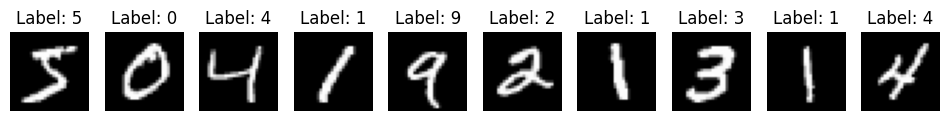

In [2]:
# 載入 MNIST 資料集並正規化
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print(f"訓練資料數量: {len(x_train)}")
print(f"測試資料數量: {len(x_test)}")

# 顯示前 10 張訓練圖片，確認資料正確
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.show()


## 3. 模型設計

In [3]:
# 建立自訂的 DNN 模型（非三層，共有五層全連接）
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28,1)),

    # 第一個隱藏層
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # 第二個隱藏層
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # 第三個隱藏層
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # 第四個隱藏層
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # 第五個隱藏層
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # 輸出層
    layers.Dense(10, activation='softmax')
])


# 編譯模型：使用 Adam 優化器、稀疏類別交叉熵損失，並以準確率作為評估指標
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 輸出模型結構檢查
model.summary()

# 設定 Callback：
# 1. ModelCheckpoint：儲存驗證資料上準確率最高的模型
checkpoint_cb = callbacks.ModelCheckpoint("best_model.keras", save_best_only=True,
                                          monitor='val_accuracy', mode='max')

# 2. EarlyStopping：若驗證準確率連續 5 個 epoch 未改善，提前停止訓練並回復最佳權重
earlystop_cb = callbacks.EarlyStopping(monitor='val_accuracy', patience=5,
                                       restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509,706 (5.76 MB)

 Trainable params: 1,505,738 (5.74 MB)

 Non-trainable params: 3,968 (15.50 KB)

## 4. 模型訓練

In [4]:
# 使用 10% 的訓練資料作為驗證資料，訓練 50 個 epoch
history = model.fit(x_train, y_train, epochs=50, batch_size=128,
                    validation_split=0.1, callbacks=[checkpoint_cb, earlystop_cb])


Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.7595 - loss: 0.7942 - val_accuracy: 0.9638 - val_loss: 0.1211
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.9468 - loss: 0.1835 - val_accuracy: 0.9722 - val_loss: 0.0961
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9604 - loss: 0.1401 - val_accuracy: 0.9725 - val_loss: 0.0975
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9667 - loss: 0.1180 - val_accuracy: 0.9773 - val_loss: 0.0821
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9695 - loss: 0.1052 - val_accuracy: 0.9773 - val_loss: 0.0868
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9752 - loss: 0.0875 - val_accuracy: 0.9820 - val_loss: 0.0706
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9767 - loss: 0.0829 - val_accuracy: 0.9802 - val_loss: 0.0752
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9774 - loss: 0.0738 - 

## 5. 模型評估與結果視覺化

313/313 - 1s - 5ms/step - accuracy: 0.9801 - loss: 0.0691
測試資料正確率: 0.9800999760627747
測試資料loss: 0.06906882673501968


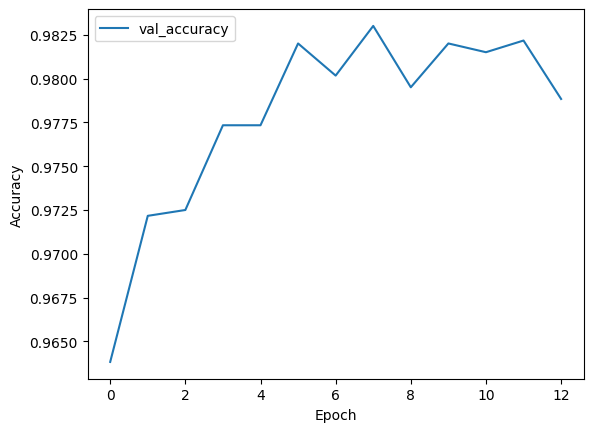

In [5]:
# 在測試資料上評估模型表現
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("測試資料正確率:", test_acc)
print("測試資料loss:", test_loss)

# 繪製驗證準確率隨 epoch 的變化曲線
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 6. 看一下實際在測試集上預測的效果

In [6]:
def predict_test_image(index):
    img = x_test[index]
    input_img = np.expand_dims(img, axis=0)  # 調整為 (1, 28, 28)
    predictions = model.predict(input_img)
    predicted_digit = np.argmax(predictions)

    # 顯示圖片與預測結果
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted digit: {predicted_digit}")
    plt.axis('off')
    plt.show()

# 使用 interact_manual 看測試集預測結果
interact_manual(predict_test_image,
                index=widgets.IntSlider(min=0, max=len(x_test)-1, step=1, value=0, description="Test Image Index"))



interactive(children=(IntSlider(value=0, description='Test Image Index', max=9999), Button(description='Run In…

<function __main__.predict_test_image(index)>

## 7. Gradio 互動介面

In [7]:
def predict_digit(image):
    # 轉為灰階、調整尺寸及正規化
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    image = tf.reshape(image, [1, 28, 28])
    image = image / 255.0
    # 圖片是白底黑字，反轉顏色
    image = 1 - image
    predictions = model.predict(image)
    predicted_digit = np.argmax(predictions)
    return {str(i): float(predictions[0][i]) for i in range(10)}


iface = gr.Interface(fn=predict_digit,
                     inputs=gr.components.Image(shape=(28,28), image_mode='RGB', invert_colors=False, source="canvas"),
                     outputs="label",
                     live=True)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.50.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://4ed945284d3d41318b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
